In [1]:

import numpy as np
# import scipy as sp
# from scipy import sparse
# from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from scipy.spatial.distance import cdist
from utils import *
import pickle as pkl

## 生成训练数据
4月30日记录数据生成的思路：

实验设计：
1. 对比不同态的模型准确度
2. 对比临界态不同密度的准确度变化

数据生成选择
1. 生成rho=2的三个态，rho=2时理论临界噪声=3.65，实际要看数据波动情况选择近似
2. 生成临界态rho=1,rho=2,rho=3三个密度数据，分别对应的理论临界噪声为3.0,3.65,4.0，具体还是要看数据波动情况选择近似

In [2]:
L=64
rho=0.3
N = L*L*rho
N

1228.8

## 将数据转化为速度场

In [3]:


# Viscek model to velocity field
def viscek_to_velocity_field(positions, velocities, box_size, resolution):
    field_shape = (int(box_size / resolution), int(box_size / resolution), 2)
    velocity_field = np.zeros(field_shape)
#     print(positions.shape, velocities)
    for p, v in zip(positions, velocities):
        i, j = (p / resolution).astype(int)
        velocity_field[i, j] += v

    return velocity_field


# Viscek model to velocity field
def viscek_to_density_field(positions, velocities, box_size, resolution):
    field_shape = (int(box_size / resolution), int(box_size / resolution))
    density_field = np.zeros(field_shape)
#     print(positions.shape, velocities)
    for index,(p, v) in enumerate(zip(positions, velocities)):
        i, j = (p / resolution).astype(int)
        density_field[i, j] += 1

    return density_field

In [4]:
16*0.3*16

76.8

In [85]:
L=64#16#10#3.65
N =1228#78#8192#2048#30
# L = 10
# N = 100
print('rho=',N/L/L)
# eta=0.5#0.2#0.45#1
r_vision=1
rho = round(N/L/L,2)
print(rho)
box_size = L
resolution = 1
lattice = int(box_size/resolution)
repeat = 20
timestep = 300#1000
seed = 2050
eta= 2#2#0.5#3.25#2#

init_data = generate_vecsek_data(N, L)
fields = np.zeros([repeat,timestep,lattice,lattice,3])
# field = np.zeros([data_all.shape[0],data_all.shape[1],lattice,lattice])
for r in enumerate(tqdm(range(repeat))):
#     init_data = generate_vecsek_data(N, L)
    data = init_data.copy()
    for i in range(timestep):
        data,adj = vecsek_update(data, eta, r_vision,L)
        del adj
#         if i >= 500:
#             fields[r,i-500,:,:,0] = viscek_to_density_field(data[:,:2], data[:,2:], box_size, resolution)
#             fields[r,i-500,:,:,1:] = viscek_to_velocity_field(data[:,:2], data[:,2:], box_size, resolution)
        
        fields[r,i,:,:,0] = viscek_to_density_field(data[:,:2], data[:,2:], box_size, resolution)
        fields[r,i,:,:,1:] = viscek_to_velocity_field(data[:,:2], data[:,2:], box_size, resolution)

print(fields.shape)
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L={L}_field_{seed}_test.pkl','wb') as f:
# with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=64_field_{seed}.pkl','wb') as f:
    pkl.dump({'field':fields},f)

rho= 0.2998046875
0.3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.36s/it]


(20, 300, 64, 64, 3)


In [71]:
def prob_density(data):
    'transform to PDF'
    b,t,l,_,f = data.shape
    data = data.mean(0)
    data = data / data.sum(axis=(1,2),keepdims=True)
    return data

In [84]:
eta=2.25
seed=2050
L=16
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L={L}_field_{seed}_test.pkl','rb') as f:
    fields = pkl.load(f)['field']
print(fields.shape)
fields = prob_density(fields)
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L={L}_pdf_{seed}.pkl','wb') as f:
    pkl.dump({'field':fields},f)
fields.shape

(500, 16, 16, 3)

In [58]:
fields.shape,fields[0,-3,:,:,0].sum()

((100, 500, 16, 16, 3), 78.0)

In [30]:
vx

array([[ 0.00226066,  0.05025032,  0.02065746, ...,  0.08495428,
         0.17570624,  0.18140126],
       [-0.07510795, -0.11627458, -0.1185886 , ..., -0.08028341,
         0.02304083,  0.12786068],
       [ 0.09845011,  0.17019203,  0.0384982 , ..., -0.05655143,
        -0.04123403,  0.0187602 ],
       ...,
       [-0.13206679, -0.07062711, -0.04438126, ..., -0.05963482,
         0.06597026,  0.15476079],
       [-0.10558923, -0.0986735 , -0.15421722, ..., -0.17755764,
        -0.15594474,  0.04600636],
       [-0.18248495, -0.01154215,  0.07240802, ..., -0.07362131,
        -0.01691555, -0.03075417]])

(20, 300)
(20, 300)


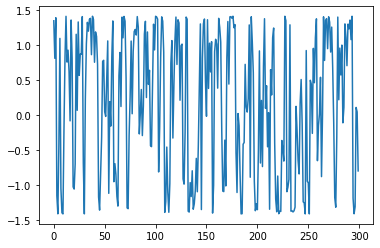

In [29]:
vx = np.sum(fields.reshape(repeat,300,-1,3)[:,:,:,1],axis=-1)/N
vy = np.sum(fields.reshape(repeat,300,-1,3)[:,:,:,2],axis=-1)/N
print(vx.shape)
v_avg = np.linalg.norm(np.array([vx,vy]),axis=0)
print(v_avg.shape)
plt.plot(((vx+vy)/v_avg)[2,:])
# print(np.mean(v_avg,axis=1))
# plt.ylim(-1.5,1.5)
plt.show()

In [27]:
eta = 2
seed = 2050
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=32_field_{seed}.pkl','rb') as f:
    field = pkl.load(f)['field'][:,:300,:,:,:]
field.shape

(20, 300, 32, 32, 3)

(20, 300)
(20, 300)


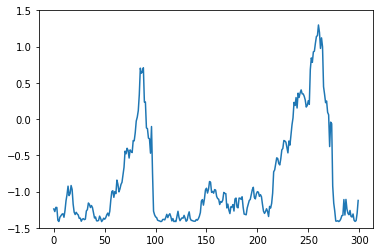

In [28]:
repeat = field.shape[0]
vx = np.sum(field.reshape(repeat,300,-1,3)[:,:,:,1],axis=-1)/N
vy = np.sum(field.reshape(repeat,300,-1,3)[:,:,:,2],axis=-1)/N
print(vx.shape)
v_avg = np.linalg.norm(np.array([vx,vy]),axis=0)
print(v_avg.shape)
plt.plot(((vx+vy)/v_avg)[0,:])
# print(np.mean(v_avg,axis=1))
plt.ylim(-1.5,1.5)
plt.show()

## 批量生成不同的eta画相变图'

In [25]:

L=16#32#64#10#3.65
N =78#307#1229#8192#2048#30
# L = 10
# N = 100
print('rho=',N/L/L)
# eta=0.5#0.2#0.45#1
r_vision=1
rho = round(N/L/L,2)
print(rho)
box_size = L
resolution = 1
lattice = int(box_size/resolution)
repeats = 50
timestep = 1000
# seed = 2051
# eta= 2.5#2#0.5#3.25#2#
etas = np.linspace(1,2.5,50)

# field = np.zeros([data_all.shape[0],data_all.shape[1],lattice,lattice])

for eta_index,eta in enumerate(etas):
#     print(eta)
#     eta_index = eta_index+2
    agents = np.zeros([repeats, 300,N,4])
    for r in tqdm(range(repeats)):
        data = generate_vecsek_data(N, L)
        for i in range(timestep):
            data,adj = vecsek_update(data, eta, r_vision,L)
            del adj
            if i > 699:
                agents[r,i-700,:,:] = data
    with open(f'./data/rho=0.3/eta_group_L={L}/eta={eta:.3f}_p={rho}.pkl','wb') as f:
        pkl.dump(agents,f)


rho= 0.3046875
0.3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.24it/s]


In [26]:
agents.shape

(50, 300, 78, 4)

In [27]:
'agent data'
L=16#64
rho=0.3
N = L*L*rho
etas = np.linspace(1,2.5,50)

order_params_16 = np.zeros([len(etas),50,300])
for i,eta in enumerate(etas):
    with open(f'./data/rho=0.3/eta_group_L={L}/eta={eta:.3f}_p={rho}.pkl','rb') as f:
        data = pkl.load(f)
    x = np.mean(data[:,:,:,2],axis=-1)[:10,:]
    y = np.mean(data[:,:,:,3],axis=-1)[:10,:]
    order_params_16[i,:,:] = np.linalg.norm(np.array([x,y]),axis=0)
order_params_16.shape

ValueError: could not broadcast input array from shape (10,300) into shape (50,300)

In [18]:
'agent data'
L=64
rho=0.3
N = L*L*rho
etas = np.linspace(1,2.5,50)

order_params_64 = np.zeros([len(etas),10,300])
for i,eta in enumerate(etas):
    with open(f'./data/rho=0.3/eta_group_L={L}/eta={eta:.3f}_p={rho}.pkl','rb') as f:
        data = pkl.load(f)
    x = np.mean(data[:,:,:,2],axis=-1)[:10,:]
    y = np.mean(data[:,:,:,3],axis=-1)[:10,:]
    order_params_64[i,:,:] = np.linalg.norm(np.array([x,y]),axis=0)
order_params_64.shape

(50, 10, 300)

In [19]:
'agent data'
L=32
rho=0.3
N = L*L*rho
etas = np.linspace(1,2.5,50)

order_params_32 = np.zeros([len(etas),10,300])
for i,eta in tqdm(enumerate(etas)):
    with open(f'./data/rho=0.3/eta_group_L={L}/eta={eta:.3f}_p={rho}.pkl','rb') as f:
        data = pkl.load(f)
    x = np.mean(data[:,:,:,2],axis=-1)[:10,:]
    y = np.mean(data[:,:,:,3],axis=-1)[:10,:]
    order_params_32[i,:,:] = np.linalg.norm(np.array([x,y]),axis=0)
order_params_32.shape

50it [00:01, 44.03it/s]


(50, 10, 300)

In [20]:
import seaborn as sns
colors = sns.color_palette('GnBu_r',5)#autumn
colors

[(0.07497116493656286, 0.4526874279123414, 0.6969319492502883),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.485121107266436, 0.801045751633987, 0.7677047289504038),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.8535178777393311, 0.9429757785467128, 0.8314186851211073)]

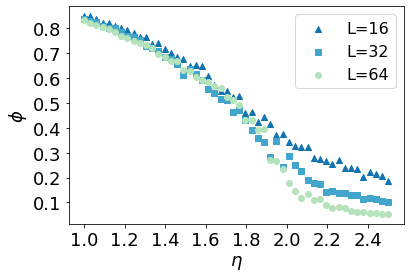

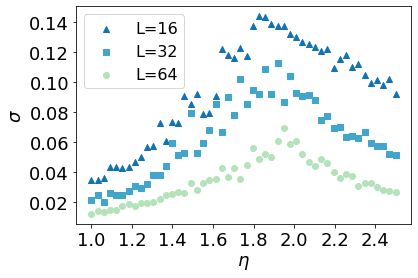

In [23]:


plt.scatter(etas, np.mean(abs(np.mean(order_params_16,axis=-1)),axis=-1),color=colors[0],marker='^',label='L=16')
plt.scatter(etas, np.mean(abs(np.mean(order_params_32,axis=-1)),axis=-1),color=colors[1],marker='s',label='L=32')
plt.scatter(etas, np.mean(abs(np.mean(order_params_64,axis=-1)),axis=-1),color=colors[3],marker='o',label='L=64')
plt.legend(fontsize=16)
set_plot_basicinf(r'$\phi$',f'$\eta$',18)
plt.show()

plt.scatter(etas, np.mean(abs(np.std(order_params_16,axis=-1)),axis=-1),color=colors[0],marker='^',label='L=16')
plt.scatter(etas, np.mean(abs(np.std(order_params_32,axis=-1)),axis=-1),color=colors[1],marker='s',label='L=32')
plt.scatter(etas, np.mean(abs(np.std(order_params_64,axis=-1)),axis=-1),color=colors[3],marker='o',label='L=64')
plt.legend(fontsize=16)
set_plot_basicinf('$\sigma$',f'$\eta$',18)
plt.show()


In [55]:
'field data'
L=32
rho=0.3
N = L*L*rho
etas = np.linspace(1,2.5,50)
# all_data = np.zeros([len(etas),9000,32,32,3])
order_params = np.zeros([len(etas),30,300])
for i, eta in tqdm(enumerate(etas)):
    with open(f'./data/rho=0.3/eta_group_L=32/eta={eta:.3f}_p=0.3_L=32_field.pkl','rb') as f:
        data = pkl.load(f)['field']
        b,t,_,_,_ = data.shape
        data  = data.reshape(b,t,L*L,3)
#         all_data[i,:,:,:,:] = data.reshape(-1,32,32,3)
        x = np.mean(data[:,:,:,1],axis=-1)
        y = np.mean(data[:,:,:,2],axis=-1)
#         print(x.shape)
        
        order_params[i,:,:] = np.linalg.norm(np.array([x,y]),axis=0)
order_params.shape

50it [00:11,  4.48it/s]


(50, 30, 300)

In [ ]:
plt.scatter(etas, np.mean(abs(np.mean(order_params,axis=-1)),axis=-1),label='L=32')
plt.scatter(etas, np.mean(abs(np.mean(order_params_64,axis=-1)),axis=-1),label='L=64')

set_plot_basicinf('<v>',f'$\eta$',14)
plt.show()

plt.scatter(etas, np.mean(abs(np.std(order_params,axis=-1)),axis=-1),label='L=32')
plt.scatter(etas, np.mean(abs(np.std(order_params_64,axis=-1)),axis=-1),label='L=64')
set_plot_basicinf('$\sigma$',f'$\eta$',14)
plt.show()
